<a href="https://colab.research.google.com/github/VARSHAJOSHY/multi-lingual-stance-dataset/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Natural Language Processing

In this week's lab, we'll explore part-of-speech tagging and dependency labeling.

The aims of this lab are:
*   Build simple natural language processing models
*   Compare your basic model with an off-the-shelf NLP tool
*   Visualise a dependency parse

**Before you start, save a copy of this lab to your drive using "File > Save a Copy in Drive".** If you skip this step, you may lose progress that you have made (e.g., if you close the browser tab or your computer crashes).

**Note:** Colab may hide some of this lab by collapsing a section. You'd see something that says "X cells hidden" (like below). Click on it to expand that section of the lab.

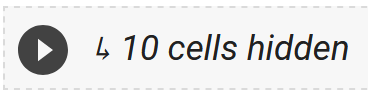

## Setting up the labtest function

As with previous labs, we'll use a `labtest` function so that you can check your code. You need to install and load it with the code below.

In [ ]:
# Installs the labtest system and loads the tests for this specific lab

!pip install -U git+https://github.com/jakelever/glasgowcs_labtest.git
from glasgowcs_labtest.tad2022.lab4 import labtest

  Cloning https://github.com/jakelever/glasgowcs_labtest.git to /tmp/pip-req-build-4e35yu7a
  Running command git clone -q https://github.com/jakelever/glasgowcs_labtest.git /tmp/pip-req-build-4e35yu7a
  Created wheel for glasgowcs-labtest: filename=glasgowcs_labtest-1.0.5-py3-none-any.whl size=27998 sha256=7e718b46b340d7edc8fbc1c2161b72ab592896250c7ec4b9214a710a5c38e259
  Stored in directory: /tmp/pip-ephem-wheel-cache-wi9djas1/wheels/2f/07/2a/4c18289f9e63ab6be7472fc264c12a4a9472956d1671e767a1
Successfully built glasgowcs-labtest


## Loading the NLP data

In this lab, we're working with part-of-speech and dependency labels. Since the Reddit dataset that we used in previous labs does not have these annotations (which we'll need for training and evaluating our system), we'll use a different dataset in this lab.

The [GUM Corpus](https://corpling.uis.georgetown.edu/gum/) contains a variety of NLP labels over domains like academic articles, interviews, fiction, vlogs, and reddit posts. It is provided in the [CONLL-U file format](https://universaldependencies.org/format.html), but this can be tricky to parse, so we've processed a version into JSON that just includes the relevant fields.

We'll now download two versions of the corpus: one for training our system, one for evaluation.

In [ ]:
!wget -O gum_train.json https://gla-my.sharepoint.com/:u:/g/personal/sean_macavaney_glasgow_ac_uk/ET5U2u2gSlxNuKguxRpfdasBJonllOx5-OxLL9Bwp0WCcw?download=1
!wget -O gum_test.json https://gla-my.sharepoint.com/:u:/g/personal/sean_macavaney_glasgow_ac_uk/Eae81oDNLGBPhPmi_EG4RbYBYVAuTcOikbH7VIIr1l_zAg?download=1

--2022-02-08 10:01:16--  https://gla-my.sharepoint.com/:u:/g/personal/sean_macavaney_glasgow_ac_uk/ET5U2u2gSlxNuKguxRpfdasBJonllOx5-OxLL9Bwp0WCcw?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gla-my.sharepoint.com/personal/sean_macavaney_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=edda543e4aa04d5cb8a82ec51a5f75ab [following]
--2022-02-08 10:01:17--  https://gla-my.sharepoint.com/personal/sean_macavaney_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=edda543e4aa04d5cb8a82ec51a5f75ab
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 4305859 (4.1M) [application/json]
Saving to: ‘gum_train.json’

gum_train.json      100%[===================>]   4.11M  4.61MB/s    in 0.9s    

2022-02-08 10:01:18 (4.61 MB/s) - ‘gum_

And let's load in the data:

In [ ]:
import json

with open('gum_train.json') as f:
    gum_train = json.load(f)

with open('gum_test.json') as f:
    gum_test = json.load(f)

print("train:", len(gum_train), "test:", len(gum_test))

train: 5660 test: 894


## Getting to know the NLP data

This data is formatted differently than the Reddit posts we were working with before.
 1. Each record represents a single sentence, rather than a whole document.
 2. The data has already been tokenised and lemmatised. This pre-processing is necessary because the part-of-speech tags and dependency labels need to be aligned with specific tokens.
 3. The data includes fields for part-of-speech tags and dependency labels.

Take a look at a sample record below:

In [ ]:
gum_train[0]

{'dep_labels': ['amod', 'ROOT', 'cc', 'amod', 'conj', 'punct'],
 'doc_url': 'https://dh2017.adho.org/abstracts/333/333.pdf',
 'id': 'GUM_academic_art-1',
 'lemmas': ['aesthetic', 'appreciation', 'and', 'Spanish', 'art', ':'],
 'pos_tags': ['ADJ', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT'],
 'tokens': ['Aesthetic', 'Appreciation', 'and', 'Spanish', 'Art', ':']}

For ease of viewing, we can also print it out in a table using [Pandas](https://pandas.pydata.org/).

In [ ]:
import pandas as pd
pd.DataFrame({
    'tokens': gum_train[0]['tokens'],
    'lemmas': gum_train[0]['lemmas'],
    'pos_tags': gum_train[0]['pos_tags'],
    'dep_labels': gum_train[0]['dep_labels'],
})

,tokens,lemmas,pos_tags,dep_labels
0,Aesthetic,aesthetic,ADJ,amod
1,Appreciation,appreciation,NOUN,ROOT
2,and,and,CCONJ,cc
3,Spanish,Spanish,ADJ,amod
4,Art,art,NOUN,conj
5,:,:,PUNCT,punct


Here we can see several part-of-speech tags and dependency labels that should look familiar from the lecture. If you need a refresher about what the tags and labels mean, see the table below or the full documentation of universal [part-of-speech tags](https://universaldependencies.org/u/pos/) and [dependency labels](https://universaldependencies.org/u/dep/).

POS Tags:

|  Tag | Name | Example(s) - Context-dependent |
| ----------- | ----------- | ----------- |
| ADJ | adjective | big, old, green |
| ADP | adposition (preposition) | in, to, during |
| ADV | adverb | very, well, exactly |
| AUX | auxiliary verb | is, has, must |
| CCONJ | coordinating conjunction | and, or, but |
| DET | determiner | a, the, some |
| INTJ | interjection | psst, ouch, hello |
| NOUN | noun | girl, cat, tree |
| NUM | numeral | five, 70, IV |
| PART | particle | ‘s, not |
| PRON | pronoun | he, her, myself, everybody |
| PROPN | proper noun | Mary, Glasgow, HBO |
| PUNCT | punctuation | .   ,   (   ) |
| SCONJ | subordinating conjunction | that, if, while |
| SYM | symbol | $   😝   ♥‿♥   1-800-COMPANY |
| VERB | verb | drank, running, sits |

Common Dependency Labels (NOTE: some are given multiple names to map between Universal Dependency label definitions and the labels provided by SpaCy.)

|  Label | Name |
| ----------- | ----------- |
| ROOT | root of sentence |
| punct | punctuation |
| prep/case | preposition or case marker |
| dobj/obj | direct object
| det | determiner |
| nsubj | nominal subject |
| amod | adjectival modifier |
| advmod | adverbial modifier |
| pobj/nmod | nominal modifier |
| conj | conjunct |
| cc | coordinating conjunction |
| ... | (More in [documentation](https://universaldependencies.org/u/dep/)) |

Let's explore the data a little more. Using the space below, can you find the most common **part-of-speech** tag and **dependency** label across all records in `gum_train`? `Counter` will be helpful for this.

Feel free to do other exploration of the data as well! (Open-ended.)

In [ ]:
from collections import Counter
# Use this space to explore the gum_train NLP data
dep_labels=[]
pos_tags=[]
for i in gum_train:
  dep_labels += ['<START>'] + i['dep_labels']
  pos_tags += ['<START>'] + i['pos_tags']

In [ ]:
Counter(dep_labels)

Counter({'<START>': 5660,
         'ROOT': 5660,
         'acl': 986,
         'advcl': 1694,
         'advmod': 4499,
         'amod': 5699,
         'appos': 758,
         'aux': 2199,
         'auxpass': 822,
         'cc': 3300,
         'ccomp': 764,
         'ccpreconj': 44,
         'compound': 3641,
         'compoundprt': 416,
         'conj': 3815,
         'cop': 1756,
         'csubj': 162,
         'csubjpass': 9,
         'dep': 637,
         'det': 8338,
         'detpredet': 94,
         'discourse': 267,
         'dislocated': 26,
         'dobj': 9639,
         'expl': 275,
         'fixed': 360,
         'flat': 1169,
         'goeswith': 9,
         'iobj': 109,
         'list': 43,
         'mark': 3302,
         'nmodnpmod': 47,
         'nmodtmod': 289,
         'nsubj': 6960,
         'nsubjpass': 753,
         'nummod': 725,
         'oblnpmod': 150,
         'obltmod': 236,
         'orphan': 44,
         'parataxis': 604,
         'pobj': 4419,
         'poss

In [ ]:
Counter(pos_tags)

Counter({'<START>': 5660,
         'ADJ': 6933,
         'ADP': 10281,
         'ADV': 4264,
         'AUX': 4803,
         'CCONJ': 3250,
         'DET': 8595,
         'INTJ': 395,
         'NOUN': 18140,
         'NUM': 2158,
         'PART': 2372,
         'PRON': 7345,
         'PROPN': 7162,
         'PUNCT': 14219,
         'SCONJ': 2048,
         'SYM': 161,
         'VERB': 11022,
         'X': 252})

You should have found that `NOUN` is the most common part-of-speech tag (18,140 occurrences) and `punct` is the most common dependency label (14,219 occurrences).

## Building a simple POS tagger

Recall that we covered Hidden Markov Models (HMMs) for performing POS tagging in the lecture. The implementation of these models are little involved (we include it as an Optional Extra for this lab). We instead focus on a simpler tagging approach: one that takes the most common POS tag for each lemma. This is a reasonable baseline because many words will predominantly serve a single function in a sentence (e.g., `Steven` will almost always be a proper noun.)

We will use the `gum_train` to build our POS Tagger, and `gum_test` to evaluate it. Thus, this is an example of *supervised learning*. The implementation will have two functions: one trains a *model*, and another that uses this model to perform inference on new text.

### Training

Let's start with the training function. Use the space below to build a function that accepts training records and returns a model in the form of a dictionary that maps lemmas to their most common POS tag found in the training data. E.g., if the most common tag for `Steven` is `PROPN` and the most common tag for `even` is `ADJ`, the resulting dictionary should include: `{"Steven": "PROPN", "even": "ADJ"}` If there is a tie for the most common tag, you can choose one arbitrarily.

In [ ]:
# Your solution here:
def train_pos_tagger(input_arr):
  print("length :",len(input_arr))

  final_dict={};

  for inp_dict in input_arr:
    i =0;
    for lem in inp_dict['lemmas']:
      if lem not in final_dict:
        final_dict[lem]=list()
      final_dict[lem].append(inp_dict['pos_tags'][i]);
      i = i+1
  return {key: Counter(value).most_common(1)[0][0] for key, value in final_dict.items()}



In [ ]:
labtest(train_pos_tagger)

----------------------------
LABTEST: Running 4 testcases
----------------------------
Input: ([{'id': 'GUM_whow_joke-40', 'doc_url': 'https://www.wikihow.com/Tell-a-Joke', 'tokens': ['it', 'just', 'depends', 'on', 'the', 'individual', 'joke', '.'], 'lemmas': ['it', 'just', 'depend', 'on', 'the', 'individual', 'joke', '.'], 'pos_tags': ['PRON', 'ADV', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], 'dep_labels': ['nsubj', 'advmod', 'ROOT', 'prep', 'det', 'amod', 'dobj', 'punct']}, {'id': 'GUM_whow_joke-41', 'doc_url': 'https://www.wikihow.com/Tell-a-Joke', 'tokens': ['Surprise', 'with', 'the', 'punchline', '.'], 'lemmas': ['surprise', 'with', 'the', 'punchline', '.'], 'pos_tags': ['VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'], 'dep_labels': ['ROOT', 'prep', 'det', 'dobj', 'punct']}, {'id': 'GUM_whow_joke-42', 'doc_url': 'https://www.wikihow.com/Tell-a-Joke', 'tokens': ['The', 'ending', 'of', 'the', 'joke', 'is', 'obviously', 'crucial', '.'], 'lemmas': ['the', 'ending', 'of', 'the', 'joke', 'be

### Inference

Next we need a function that uses the trained model to produce POS tags for a new sequence. For a given lemma, we can just return the majority class from the model.

We have a problem though: what about words that we didn't encounter during training? For these cases, we will just return the most common POS tag (`NOUN`).

Use the space below to write a function that accepts your trained model (as a dict) and a sequence for evaluation (as a list of lemmas), and returns a list of POS tags aligned with each lemma. For instance, `infer_pos_tags({'Steven': 'PROPN', 'even': 'ADJ'}, {"lemmas": ["Steven", "Spielberg"]})` should return `["PROPN", "NOUN"]`.

In [ ]:
# Your solution here
def infer_pos_tags(train_model,lemma_list):
  op_array=[]
  print("train_model : ",train_model)
  print("lemma_list : ",lemma_list['lemmas'])

  for lemma in lemma_list['lemmas']:
    if lemma in train_model:
      op_array.append(train_model[lemma])
    else:
      op_array.append("NOUN");
  return op_array


In [ ]:
infer_pos_tags({'Steven': 'PROPN', 'even': 'ADJ'}, {"lemmas": ["Steven", "Spielberg"]})

['NOUN']

In [ ]:
labtest(infer_pos_tags)

----------------------------
LABTEST: Running 1 testcases
----------------------------
Input: ({']': 'PUNCT', 'a': 'DET', 'about': 'ADP', 'additional': 'ADJ', 'also': 'ADV', 'and': 'CCONJ', 'change': 'VERB', 'come': 'VERB', 'countless': 'ADJ', 'crucial': 'ADJ'}, {'lemmas': ['crucial', 'and', 'oov', 'about', 'a', 'a', ']']}). Running... 
train_model :  {']': 'PUNCT', 'a': 'DET', 'about': 'ADP', 'additional': 'ADJ', 'also': 'ADV', 'and': 'CCONJ', 'change': 'VERB', 'come': 'VERB', 'countless': 'ADJ', 'crucial': 'ADJ'}
lemma_list :  ['crucial', 'and', 'oov', 'about', 'a', 'a', ']']
OK.
----------------------------
1 testcases PASSED
----------------------------


## POS evaluation

Now let's see how well your POS tagger performs!

We will use Accuracy as a measure of performance. This measure is calculated by dividing the number of correctly-labeled tokens by the total number of tokens. Other measures can shed more light on performance, such as precision, recall, and F1 scores; these will be introduced in upcoming lectures.

In [ ]:
def eval_pos_accuracy(model, inference_fn, test_records):
  count_correct = 0
  total_count = 0
  for record in test_records:
    gold_tags = record['pos_tags']
    pred_tags = inference_fn(model, record)
    count_correct += sum(gold == pred for gold, pred in zip(gold_tags, pred_tags))
    total_count += len(gold_tags)
  return count_correct/total_count

In [ ]:
pos_model = train_pos_tagger(gum_train)
eval_pos_accuracy(pos_model, infer_pos_tags, gum_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.8604464726196349

You should get an accuracy of around 0.860. It's not perfect, but also not so bad for such a simple procedure!

Let's see where it makes mistakes. We can build a confusion matrix to do this.

In [ ]:
def pos_confusion_matrix(model, inference_fn, test_records):
  pd.set_option('display.max_columns', None)
  true = []
  pred = []
  for record in test_records:
    true.extend(record['pos_tags'])
    pred.extend(inference_fn(model, record))
  matrix = pd.crosstab(pd.Series(pred), pd.Series(true))
  order = matrix.sum(axis=0).sort_values(ascending=False).index
  return matrix.reindex(order, axis=0).reindex(order, axis=1).fillna(0).astype(int) \
      .rename_axis("Pred POS", axis=0).rename_axis("True POS", axis=1) \
      .style.background_gradient('Blues', axis=None) \
      .applymap(lambda x: 'background-color: white; color: #BBBBBB;' if x == 0 else None)

In [ ]:
pos_confusion_matrix(pos_model, infer_pos_tags, gum_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 ['build', 'a', 'shelter', 'box', 'in', 'your', 'garden', 'to', 'attract', 'some', 'onto', 'your', 'property', '.']
train_model :  {'aesthetic': 'ADJ', 'appreciation': 'NOUN', 'and': 'CCONJ', 'Spanish': 'ADJ', 'art': 'NOUN', ':': 'PUNCT', 'insight': 'NOUN', 'from': 'ADP', 'eye-tracking': 'NOUN', 'Claire': 'PROPN', 'Bailey': 'PROPN', '-': 'PUNCT', 'Ross': 'PROPN', 'claire.bailey-ross@port.ac.uk': 'PROPN', 'University': 'PROPN', 'of': 'ADP', 'Portsmouth': 'PROPN', ',': 'PUNCT', 'Unite': 'VERB', 'Kingdom': 'PROPN', 'Andrew': 'PROPN', 'Beresford': 'PROPN', 'a.m.beresford@durham.ac.uk': 'PROPN', 'Durham': 'PROPN', 'Daniel': 'PROPN', 'Smith': 'PROPN', 'daniel.smith2@durham.ac.uk': 'PROPN', 'Warwick': 'PROPN', 'c.l.h.warwick@durham.ac.uk': 'PROPN', 'how': 'SCONJ', 'do': 'AUX', 'person': 'NOUN', 'look': 'VERB', 'at': 'ADP', 'experience': 'NOUN', '?': 'PUNCT', 'which': 'PRON', 'element': 'NOUN', 'specific': 'ADJ', 'artwork': 'NOUN', 'they': 'PRON', 'focus': 'VERB', 'on': 'ADP', 'museum': 'NOUN'

True POS,NOUN,PUNCT,ADP,VERB,DET,PROPN,ADJ,PRON,AUX,ADV,CCONJ,NUM,PART,SCONJ,INTJ,SYM,X
Pred POS,,,,,,,,,,,,,,,,,
NOUN,2740,0,3,244,2,678,225,0,0,38,0,64,0,0,3,5,10
PUNCT,0,2057,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
ADP,0,0,1564,5,0,0,6,0,0,69,0,0,0,62,12,0,0
VERB,156,0,0,1258,0,0,10,0,1,0,0,0,0,1,2,0,0
DET,1,0,0,0,1372,0,0,31,0,12,10,0,0,0,2,0,0
PROPN,5,0,0,0,0,532,14,0,0,1,0,0,0,0,0,0,1
ADJ,45,0,2,20,3,31,815,0,0,19,0,0,0,0,0,0,0
PRON,0,0,2,0,20,1,0,1045,0,12,0,0,0,43,0,0,0
AUX,3,0,0,135,0,0,0,0,720,0,0,0,0,0,0,0,0


Recall that in a confusion matrix, the columns represent the true (gold) tags, and the rows represent the predicted tags.

Notice from the above matrix that many of the mistakes the model makes are the over-application of the NOUN tag -- mostly to ADJ, PROPN, and VERB. This is probably due to NOUN being the default value lemmas that were not encountred in the training data. Can you think of changes that could be made to the model training or inference to improve the performance on these OOV lemmas? (Open-ended.)

Take a look through the rest of the confusion matrix -- can you identify any other intersting patterns? (Open-ended.)

## SpaCy's POS tagger

We've used the [SpaCy](https://spacy.io/) package in prior labs for tokenisation. It provide a bunch of other NLP functionality, too, including POS tagging. Its models are already trained, so there's no need to train our own model for it. Below, we provide an implementation for inference.

In [ ]:
import spacy
spacy_model = spacy.load('en_core_web_sm')
spacy_model.tokenizer = spacy_model.tokenizer.tokens_from_list

def spacy_infer_pos_tags(model, record):
  return [t.pos_ for t in model(record['tokens'])]

Now let's see how well SpaCy performs. First, let's test the accuracy. This will take a little longer because SpaCy uses a **XXX** POS tagger.

In [ ]:
eval_pos_accuracy(spacy_model, spacy_infer_pos_tags, gum_test)

0.9060187469166255

That's better; the accuracy is now around 0.906.

Let's see the mistakes that the SpaCy model makes by using a confusion matrix:

In [ ]:
pos_confusion_matrix(spacy_model, spacy_infer_pos_tags, gum_test)

True POS,NOUN,PUNCT,ADP,VERB,DET,PROPN,ADJ,PRON,AUX,ADV,CCONJ,NUM,PART,SCONJ,INTJ,SYM,X
Pred POS,,,,,,,,,,,,,,,,,
NOUN,2811,0,0,35,0,55,25,0,2,13,0,1,1,0,0,5,5
PUNCT,0,2057,0,0,0,1,0,0,3,0,0,0,1,0,0,8,0
ADP,2,0,1569,1,0,0,3,0,0,31,0,0,0,53,0,0,0
VERB,23,0,0,1440,0,6,12,0,164,1,0,0,0,1,2,0,1
DET,1,0,0,0,1395,0,0,356,0,9,4,0,1,5,0,0,0
PROPN,65,0,0,23,0,1167,65,0,0,6,0,0,11,0,2,2,8
ADJ,33,0,0,32,1,10,986,0,0,13,0,0,0,0,1,0,1
PRON,22,0,0,0,0,0,0,710,0,2,0,0,0,0,0,0,0
AUX,0,0,0,130,0,0,0,0,552,0,0,0,1,0,0,0,0


What kind of POS-tagging mistakes does SpaCy make? Are these similar to the mistakes made by your simple POS tagger? (Open-ended.)

## Building and evalulating a dependency labeler

Recall that dependency labels indicate the role of a particular words in a sentence (e.g., subjects and direct objects).

Let's see how well our simple classifier can perfom this labeling. Although this baseline doesn't make as much sense for dependency labeling as it does for part-of-speech tagging, it still may be a useful baseline to put the performance of other systems in context.

Use the space below to write functions to train and infer dependency labels by finding the majority class for each lemma. Here again, you can use the most common dependency label in the corpus during inference for OOV lemmas.

*(Feel free to adapt code from your POS tagging implementation for this task.)*

In [ ]:
## your solution here
def train_dep_labeler(records):
  print(len(records))
  return "hi"

In [ ]:
labtest(train_dep_labeler)

----------------------------
LABTEST: Running 4 testcases
----------------------------
Input: ([{'id': 'GUM_whow_joke-40', 'doc_url': 'https://www.wikihow.com/Tell-a-Joke', 'tokens': ['it', 'just', 'depends', 'on', 'the', 'individual', 'joke', '.'], 'lemmas': ['it', 'just', 'depend', 'on', 'the', 'individual', 'joke', '.'], 'pos_tags': ['PRON', 'ADV', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], 'dep_labels': ['nsubj', 'advmod', 'ROOT', 'prep', 'det', 'amod', 'dobj', 'punct']}, {'id': 'GUM_whow_joke-41', 'doc_url': 'https://www.wikihow.com/Tell-a-Joke', 'tokens': ['Surprise', 'with', 'the', 'punchline', '.'], 'lemmas': ['surprise', 'with', 'the', 'punchline', '.'], 'pos_tags': ['VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'], 'dep_labels': ['ROOT', 'prep', 'det', 'dobj', 'punct']}, {'id': 'GUM_whow_joke-42', 'doc_url': 'https://www.wikihow.com/Tell-a-Joke', 'tokens': ['The', 'ending', 'of', 'the', 'joke', 'is', 'obviously', 'crucial', '.'], 'lemmas': ['the', 'ending', 'of', 'the', 'joke', 'be

AssertionError: ignored

In [ ]:
labtest(infer_dep_labels)

Now let's see how well this performs on our test data.

In [ ]:
def eval_dep_accuracy(model, inference_fn, test_records):
  count_correct = 0
  total_count = 0
  for record in test_records:
    gold_tags = record['dep_labels']
    pred_tags = inference_fn(model, record)
    count_correct += sum(gold == pred for gold, pred in zip(gold_tags, pred_tags))
    total_count += len(gold_tags)
  return count_correct/total_count

def dep_confusion_matrix(model, inference_fn, test_records):
  pd.set_option('display.max_columns', None)
  true = []
  pred = []
  for record in test_records:
    true.extend(record['dep_labels'])
    pred.extend(inference_fn(model, record))
  matrix = pd.crosstab(pd.Series(pred), pd.Series(true))
  order = matrix.sum(axis=0).sort_values(ascending=False).index
  return matrix.reindex(order, axis=0).reindex(order, axis=1).fillna(0).astype(int) \
      .rename_axis("Pred POS", axis=0).rename_axis("True POS", axis=1) \
      .style.background_gradient('Blues', axis=None) \
      .applymap(lambda x: 'background-color: white; color: #BBBBBB;' if x == 0 else None)

In [ ]:
dep_model = train_dep_labeler(gum_train)
eval_dep_accuracy(dep_model, infer_dep_labels, gum_test)

You should get around 0.607 accuracy for dependency labeling. We can again inspect the confusion matrix.

In [ ]:
dep_confusion_matrix(dep_model, infer_dep_labels, gum_test)

Many of the mistakes our model makes are again due to the default label for OOV terms. But it also frequently confuses labels like `nsubj', `dobj`, and `pobj`. This makes sense because the same word (usually nouns or proper nouns) can serve any of these roles in a sentence. E.g., in the following sentences "Steven" acts as the following, depending on how it is used in the sentence:

 - `nobj`: "Steven gave Kelly an apple."
 - `dobj`: "Kelly gave Steven an apple."
 - `pobj`: "Kelly gave an apple to Steven."

Based on this observation, what changes could you make to your model to help it perfom better for these cases? (Open-ended.)

We can also use SpaCy for dependency labeling.

In [ ]:
def spacy_infer_dep_labels(model, record):
  return [t.dep_ for t in model(record['tokens'])]

In [ ]:
eval_dep_accuracy(spacy_model, spacy_infer_dep_labels, gum_test)

0.7658485446472619

That's way better accuracy than our model, but it's still not perfect. Let's use a confusion matrix to see what mistakes SpaCy makes with dependency labeling:

In [ ]:
dep_confusion_matrix(spacy_model, spacy_infer_dep_labels, gum_test)

What kinds of mistakes does the SpaCy dependency labeler make? How do these compare with the mistakes made by your labeler? (Open-ended.)

## Full dependency parse

Of course there's more to dependency parsing than just the labels; there are also the edges between tokens that indicate syntactic dependence.

In the lecture covered a transition-based parser. These systems can be complicated to train, but luckily SpaCy provides a trained parser.

In SpaCy, a token's syntactic parent can be found with its `.head` attribute. We can make a table that shows all these parents alongside their labels:

In [ ]:
sentence = gum_test[0]['tokens']
parse = spacy_model(sentence)
pd.DataFrame({
    'tokens': [str(t) for t in parse],
    'parent': [str(t.head) for t in parse],
    'label': [t.dep_ for t in parse],
})

Here we see the root of the sentence is `prevalence`. `The`, `of`, `across`, and `:` are all children of `prevalence`.

This format can be difficult to see the relationships between each token, however. We can build a visualisation of this tree using SpaCy's `displacy.render` function:

In [ ]:
from spacy import displacy

displacy.render(spacy_model(gum_test[0]['tokens']), style="dep", jupyter=True, options={'distance': 90})

That's much easier to see what's going on! We can now easily see chains like "of discrimination" and subtrees like "in contemporary America".

Go ahead and try visualising other sentences using displacy. You can even make up your own! (Open-ended.)

## End

This is the end of Lab 4. Let us know if you encounter any issues!. Remember we are here to help!. Please submit the lab on the Moodle submission page!

## Optional Extras

- What values would a Hidden Markov Model for POS tagging need to compute?
- Build a Hidden Markov Model POS tagger. How well does it perform compare to your simple baseline? How well does it perform compared to SpaCy's tagger?